In [1]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot

from sklearn import tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def read_by_lines(list_file, dir_path, list_filled):
    
    for labels in list_file:
    
        with open(dir_path + labels, "r") as file:

            for readline in file: 
                line_strip = readline.strip()
                
                if line_strip == "1":
                    list_filled.append("unfair")
                elif line_strip == "-1":
                    list_filled.append("fair")
                else:
                    list_filled.append(line_strip)

    return list_filled

In [3]:
dir_label = "data/Labels/"
dir_sentences = "data/Sentences/"

list_file_labels = os.listdir(dir_label)
list_file_sentences = os.listdir(dir_sentences)

list_label = []
list_sentences = []

list_label = read_by_lines(list_file_labels, dir_label, list_label)
list_sentences = read_by_lines(list_file_sentences, dir_sentences, list_sentences)

In [4]:
print("NUMBER OF LABELS:", len(list_label))
print("NUMBER OF UNFAIR CASES:", list_label.count('unfair'))
print("NUMBER OF FAIR CASES:", list_label.count('fair'))

NUMBER OF LABELS: 9414
NUMBER OF UNFAIR CASES: 1032
NUMBER OF FAIR CASES: 8382


In [5]:
print("NUMBER OF SENTENCES:", len(list_sentences))

NUMBER OF SENTENCES: 9414


# Length of Sentence Analyses per Class

In [6]:
# CREATE A DICTIONARY FOR SENTENCES

dict_cases = {}
dict_cases['fair'] = []
dict_cases['unfair'] = []

for idx, label in enumerate(list_label):
    
    dict_cases[label].append(list_sentences[idx])

In [7]:
list_fair_sentence_length = []
list_unfair_sentence_length = []

for sentence in dict_cases['fair']:
    list_fair_sentence_length.append(len(sentence))
    
for sentence in dict_cases['unfair']:
    list_unfair_sentence_length.append(len(sentence))

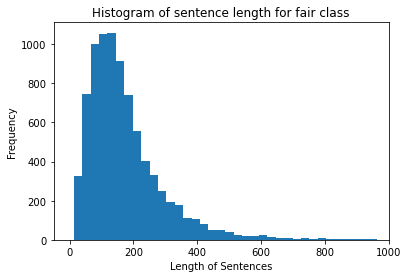

In [8]:
plt.hist(list_fair_sentence_length, bins = 100)
plt.xlim(-50, 1000)
plt.title("Histogram of sentence length for fair class")
plt.xlabel("Length of Sentences")
plt.ylabel("Frequency")
plt.show()

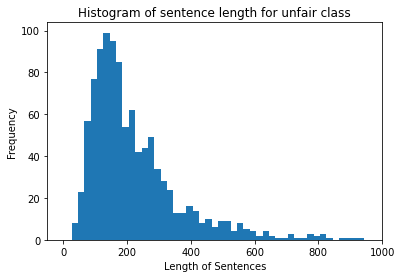

In [9]:
plt.hist(list_unfair_sentence_length, bins = 100)
plt.xlim(-50, 1000)
plt.title("Histogram of sentence length for unfair class")
plt.xlabel("Length of Sentences")
plt.ylabel("Frequency")
plt.show()

# Per Document Analyses

In [10]:
def read_by_lines_per_document(document_name, dict_documents):
    
    list_labels = []
    
    ###### read labels ######
    with open("data/Labels/" + document_name, "r") as file:

        for readline in file: 
            line_strip = readline.strip()

            if line_strip == "1":
                list_labels.append("unfair")
            else:
                list_labels.append("fair")
      
    ###### read sentences ####
    with open("data/Sentences/" + document_name, "r") as file:
        
        for idx, readline in enumerate(file):
            
            line_strip = readline.strip()

            if list_labels[idx] == "unfair":
                dict_documents[document]["unfair"].append(line_strip)
            else:
                dict_documents[document]["fair"].append(line_strip)

    
    return dict_documents

In [11]:
dict_documents = {}

for document in list_file_labels:
        
    dict_documents[document] = {}
    dict_documents[document]['fair'] = []
    dict_documents[document]['unfair'] = []
    
    dict_documents = read_by_lines_per_document(document, dict_documents)

In [12]:
dict_documents_sentence_length = {}

for document in dict_documents:
    
    dict_documents_sentence_length[document] = {}
    dict_documents_sentence_length[document]['fair'] = []
    dict_documents_sentence_length[document]['unfair'] = []
    
    for label in dict_documents[document]:
        for sentence in dict_documents[document][label]:
            dict_documents_sentence_length[document][label].append(len(sentence))


In [13]:
len(dict_documents_sentence_length)

50

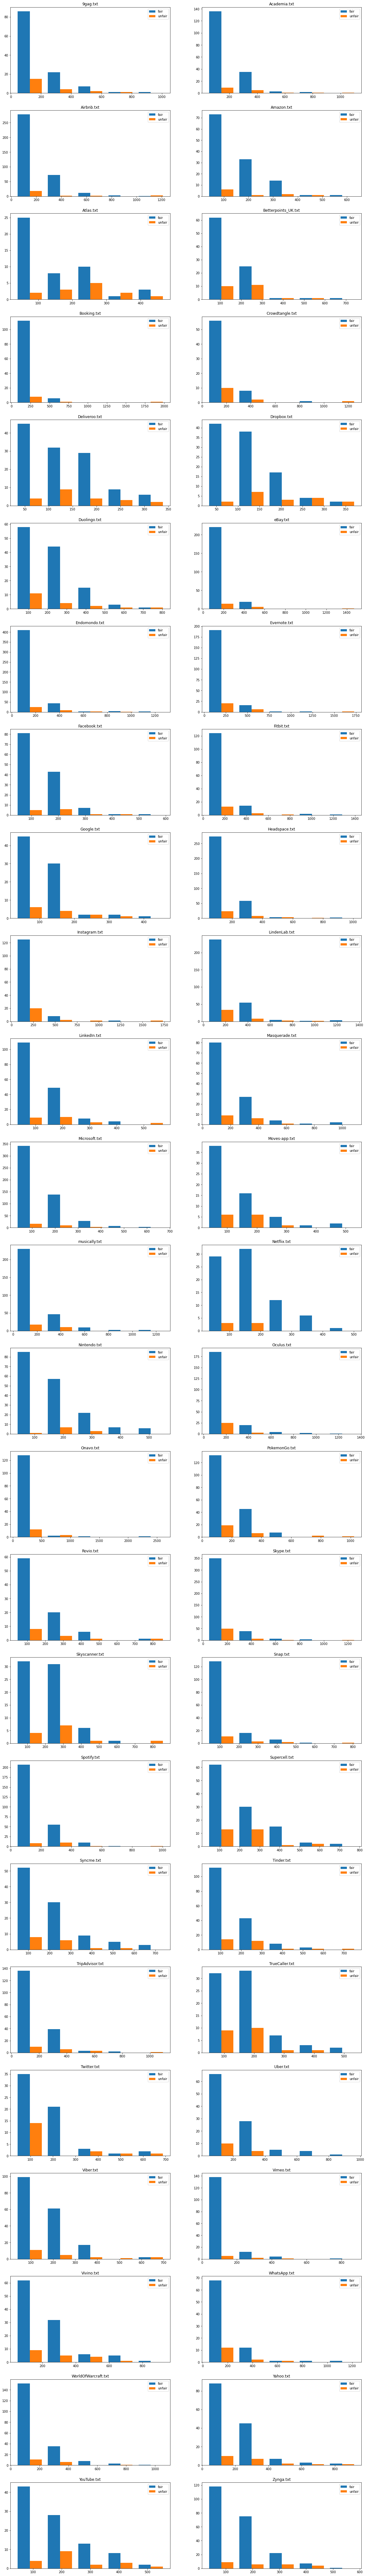

In [15]:
# create subplots
fig, axs = plt.subplots(25, 2, figsize=(20, 150))
axs = axs.ravel()

for idx, document in enumerate(dict_documents_sentence_length):
    #print(document)
    axs[idx].hist([dict_documents_sentence_length[document]['fair'], dict_documents_sentence_length[document]['unfair']], bins=5, label=['fair', 'unfair'])
    axs[idx].set_title(document)
    axs[idx].legend(loc='upper right')
    
    
#plt.show()

## Tokenization

In [167]:
def tokenize(txt):
    dirty_tokens = re.split(' +', txt)  # split words
    
    # remove all non-alphanumerics
    clean_tokens = [re.sub(r'\W', '', t).lower() for t in dirty_tokens]
    
    """
    cond = True
    cnt_pop = 0
    
    while cond:
        for idx, token in enumerate(clean_tokens):
            if len(token) == 0:
                cnt_pop += 1
                clean_tokens.pop(idx)
            
            if idx == len(clean_tokens)-cnt_pop:
                cond = False
    """
                
    return clean_tokens


def build_vocabulary(sentences):
    vocab_counts = {}

    for sentence in sentences:
        for token in sentence:
            if token in vocab_counts:
                vocab_counts[token] += 1
            else:
                vocab_counts[token] = 1
    
    return vocab_counts

In [168]:
token_list = []

cnt = 0
for sentence in list_sentences:
    token_list.append(tokenize(sentence))

In [169]:
token_counts = build_vocabulary(token_list)

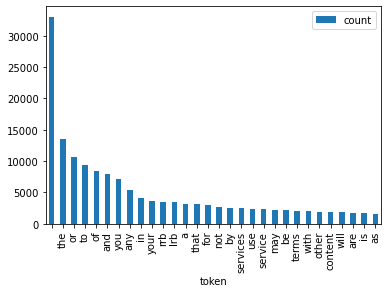

In [170]:
vocab_df = pd.DataFrame([{'token': t, 'count': c} for t, c in token_counts.items()])
vocab_df = vocab_df.set_index(['token'])
vocab_df.sort_values('count', ascending=False)[:30].plot.bar()
plt.show()

## Basic TFIDF vectorization with sklearn

In [147]:
train_data = list_sentences[:8000]
test_data  = list_sentences[8000:]

train_label = list_label[:8000]
test_label  = list_label[8000:]


print("NUMBER OF TRAIN LABELS:", len(list_label[:8000]))
print("NUMBER OF TRAIN UNFAIR CASES:", list_label[:8000].count('unfair'))
print("NUMBER OF TRAIN FAIR CASES:", list_label[:8000].count('fair'))
print("--------------------------------------------------")
print("NUMBER OF TEST LABELS:", len(list_label[8000:]))
print("NUMBER OF TEST UNFAIR CASES:", list_label[8000:].count('unfair'))
print("NUMBER OF TEST FAIR CASES:", list_label[8000:].count('fair'))

NUMBER OF TRAIN LABELS: 8000
NUMBER OF TRAIN UNFAIR CASES: 877
NUMBER OF TRAIN FAIR CASES: 7123
--------------------------------------------------
NUMBER OF TEST LABELS: 1414
NUMBER OF TEST UNFAIR CASES: 155
NUMBER OF TEST FAIR CASES: 1259


In [158]:
vectorizer = TfidfVectorizer(min_df=5)
vectorizer = vectorizer.fit(train_data)
tfidf_features_skl = vectorizer.get_feature_names()


In [149]:
train_tfidf_skl = vectorizer.transform(train_data).toarray()
test_tfidf_skl = vectorizer.transform(test_data).toarray()

In [150]:
train_tfidf_skl.shape

(8000, 2643)

In [159]:
test_tfidf_skl.shape

(1414, 2643)

In [171]:
def top_tfidf_features(row, features, top_n=15):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_features_in_doc(Xtr, features, row_id, top_n=15):
    ''' Top tfidf features in specific document (matrix row) '''
    xtr_row = Xtr[row_id]
    if type(xtr_row) is not np.ndarray:
        xtr_row = xtr_row.toarray()
    row = np.squeeze(xtr_row)
    return top_tfidf_features(row, features, top_n)


def top_mean_features(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids]
    else:
        D = Xtr
    if type(D) is not np.ndarray:
        D = D.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_features(tfidf_means, features, top_n)


def top_features_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = {}
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_features(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        #print("feats_df:", feats_df)
        feats_df.label = label
        dfs[label] = feats_df
    return dfs

def span_top_tfidf(spans_txt, spans_tfidf, features, index):
    print('span text:\n'+spans_txt[index]+'\n')
    print(top_features_in_doc(spans_tfidf, features, index))

### Examine the top TFIDF values of tokens in a sentence

In [172]:
span_top_tfidf(train_data, 
               train_tfidf_skl,
               tfidf_features_skl,
               random.randint(0, len(train_data)))

span text:
airbnb in turn grants you a limited , non-exclusive , non-sublicensable , revocable , non-transferable license to use verified images outside of the airbnb platform solely for your personal and non-commercial use .

          feature     tfidf
0             non  0.604577
1          airbnb  0.303780
2        verified  0.247820
3       revocable  0.213419
4          grants  0.212462
5   sublicensable  0.208887
6          images  0.196352
7    transferable  0.193574
8         outside  0.190523
9             use  0.170808
10      exclusive  0.170413
11         solely  0.167385
12     commercial  0.166669
13       platform  0.165283
14       personal  0.146863


### Examine features with highest average TFIDF score per class

In [175]:
dfs = top_features_by_class(train_tfidf_skl, 
                            train_label,
                            tfidf_features_skl)

In [174]:
dfs.keys()

dict_keys(['fair', 'unfair'])

In [156]:
dfs['unfair']

,feature,tfidf
0,yourself,NaN
1,exceptions,NaN
2,except,NaN
3,exceed,NaN
4,example,NaN
5,everyone,NaN
6,every,NaN
7,evernote,NaN
8,events,NaN
9,event,NaN


## SVM Model

In [176]:
clf = SVC()
clf = clf.fit(train_tfidf_skl, train_label)

In [177]:
print('TRAIN:\n'+classification_report(train_label, 
                                       clf.predict(train_tfidf_skl)))
print('TEST:\n'+classification_report(test_label,
                                      clf.predict(test_tfidf_skl)))

TRAIN:
              precision    recall  f1-score   support

        fair       0.99      1.00      0.99      7123
      unfair       0.99      0.88      0.93       877

    accuracy                           0.99      8000
   macro avg       0.99      0.94      0.96      8000
weighted avg       0.99      0.99      0.99      8000

TEST:
              precision    recall  f1-score   support

        fair       0.95      0.99      0.97      1259
      unfair       0.90      0.57      0.70       155

    accuracy                           0.95      1414
   macro avg       0.92      0.78      0.83      1414
weighted avg       0.94      0.95      0.94      1414



In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)
X_train_tfidf.shape